In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
batch_size = 16

training_data = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True,
    transform=ToTensor()
)

training_loader = torch.utils.data.DataLoader(
    training_data, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False
)

In [3]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool_1 = nn.MaxPool2d(kernel_size=2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool_2 = nn.MaxPool2d(kernel_size=2) 
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool_3 = nn.MaxPool2d(kernel_size=2)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64 * 3 * 3, 10)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool_2(x)

        x = self.conv_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool_3(x)      

        x = x.view(x.size(0), -1)
        x = self.out(x)
        
        return x

In [4]:
model = MnistCNN()
print(model)

MnistCNN(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=576, out_features=10, bias=True)
)


In [5]:
def train_model(model, criterion, optimizer, epochs=5, device='cpu'):
    model = model.to(device)

    for epoch in range(epochs):
        model = model.train()
        for batch_idx, (data, target) in enumerate(training_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f"epoch: {epoch}    loss: {loss}")

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, epochs=15, device='cuda')

epoch: 0    loss: 0.014288055710494518
epoch: 1    loss: 0.05990472435951233
epoch: 2    loss: 0.01702599972486496
epoch: 3    loss: 0.13961085677146912
epoch: 4    loss: 0.0012830129126086831
epoch: 5    loss: 0.013419191353023052
epoch: 6    loss: 0.12903578579425812
epoch: 7    loss: 0.0004352628602646291
epoch: 8    loss: 0.00043405123869888484
epoch: 9    loss: 0.0006175627349875867
epoch: 10    loss: 0.0033740492071956396
epoch: 11    loss: 0.0008724543149583042
epoch: 12    loss: 0.011263213120400906
epoch: 13    loss: 0.05865030735731125
epoch: 14    loss: 0.00400535250082612


In [7]:
def test_model(model, device='cpu'):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += target.size(0)
            correct += (predicted == target).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [8]:
test_model(model, 'cuda')

Test Accuracy: 99.09%


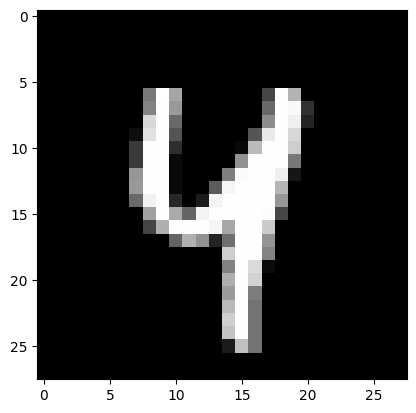

In [9]:
img, label = test_data[42]
plt.imshow(img.squeeze(), cmap="gray")

In [10]:
def inference(model, entry_idx, device='cpu'):
    model.to(device)
    model.eval()

    with torch.no_grad():
        data, target = test_data[entry_idx]
        data = data.unsqueeze(0).to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)

        print(f'Predicted digit: {predicted[0]}')

In [11]:
inference(model, 42, 'cuda')

Predicted digit: 4
